# INFO8010: Homework 2

In the previous homework, you learned how to program your first neural network starting from the very first principles of deep learning. If you managed to solve last assignment without any problems **congratulations!** If that was not the case **don't worry**, here's a second assignment for you which you can use to get better at deep learning.

In this homework we will see some slighly more complicated deep learning concepts: we will start by taking a look at some of PyTorch's functionalities that are necessary for training deep networks efficiently. We will then train our first neural networks for tackling different image classification tasks, learn to build custom datasets and explore how to train a CNN.  

The strucutre of the notebook is identical to the one of the previous homework. Similarly to last time, you have to submit the notebook **with your solutions** to the exercises. When you encounter a `# your code` comment, you have to write some code yourself and you have to discuss the code/results when you see the instruction

> your discussion

Without further ado let's start by importing the libraries we will need throughout this assignment!

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from PIL import Image
from torchvision import datasets, transforms, utils

In [ ]:
# As of 2022/02/23, the CIFAR10 dataset SSL certificate is outdated which prevents its download.
# The following deactivates the verification of the SSL certificates, but
# never reproduce this unless you absolutely trust the source.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 1. Dataloaders

Today's first concept are PyTorch's dataloaders. As you have seen during the theoretical lectures, one of the main ingredients for successfully training deep learning models is data, **lots of data**. 

As you can easily imagine, it is not possible to load datasets of millions of images into the memory of your machine. Furthermore, these images come in a form that does not make it possible to exploit the tensor operations we have seen in the previous assignment. 

To deal with these issues (and many more of them) we can use [dataloaders](https://pytorch.org/docs/stable/data.html), a data loading utility that allows us to deal with large datasets efficiently. In what follows, you are given your first example of dataloader which will use the popular [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

Let's explain what we just did. Thanks to PyTorch's [torchvision](https://pytorch.org/vision/stable/index.html) sub-library, we just downloaded the CIFAR10 dataset on our machine. The dataset was stored in the `./data` folder and comes in two different forms thanks to the use of the `train` flag: a version that can be used as training set, and a version that can be used as testing set. These two datasets are subclasses of `torch`'s `data.Dataset` class. We will see later what this `data.Dataset` class consists in exactly. Torchvision also allows us to define a set of image transformations which we have defined at the beginning of this cell: in this case we would like to convert our images to tensors, see the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor) for an exact description of this transformation.

Now that we have defined which dataset we would like to use, and the form in which we would like to have our images, we can create our first data loader. Data loaders are objects over which you can iterate and that load, transform and return mini-batches of inputs/targets at each iteration. The advantage of data loaders is that they (can) perform pre-processing of the data in parallel, i.e. in several concurrent worker pools.

Here, we create two data loaders that return mini-batches of 4 elements at each iteration. When using stochastic gradient descent (SGD), the training data loader should shuffle the training dataset. 

In [ ]:
trainloader = data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Before training anything, let's take a look at the images we just downloaded.

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

images, labels = next(iter(trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

The `transforms` module comes also in as very handy for performing other type of data transformations: here's an example which transforms the CIFAR10 images into gray scaled images.

In [ ]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
gray_scaled_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
gray_scaled_trainloader = data.DataLoader(gray_scaled_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(gray_scaled_trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

### 1.1 Transforms

Al remembered from the theoretical lectures that one way to make neural networks converge faster is to **normalize** the pixel values. He wrote the following code snippet to normalize his training set, but he encountered an error.

In [ ]:
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor(),
])
bugged_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
bugged_trainloader = data.DataLoader(bugged_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(bugged_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

Fix his mistake.

In [ ]:
# your code
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
fixed_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
fixed_trainloader = data.DataLoader(fixed_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(fixed_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

Al also remembers that, with image datasets, a common practice to increase the robustness of neural networks is **data augmentation**. He wants to apply random flips (vertical and horizontal) and random color changes to his training set, but he does not know how to. Could you help him?

In [ ]:
# your code
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augmented_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
augmented_trainloader = data.DataLoader(augmented_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(augmented_trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])


### 1.2 Running operations on a GPU

As you may know, one important aspect of deep learning is that large models can be trained efficiently on specialized hardwares such as Graphical Processing Units (GPUs) or Tensorial Processing Units (TPUs). PyTorch allows you to perform operations on GPUs very easily by transferring the concerned models and/or tensors to GPUs.

However, to do so, you need a CUDA compatible GPU.

In [21]:
torch.cuda.is_available()

True

If the result of the previous cell is `True`, everything is ready to run on the GPU and you can continue. Otherwise it means you do not have any GPU that is compatible with the `torch` version installed on your machine. In this case, we invite you to use [Google Colab](https://colab.research.google.com/) to do the rest of this homework. Do not forget to ask Colab for a GPU (in Runtime > Change runtime type > Hardware accelerator).

In [22]:
device = 'cuda'

Let's compare the speed of tensor operations on GPU and CPU. 

In [ ]:
A = torch.randn(1000, 100000)
B = torch.randn(100000, 1)

# on CPU
%timeit A @ B

In [ ]:
A = torch.randn((1000, 100000), device=device)
B = torch.randn((100000, 1), device=device)

# on GPU
%timeit A @ B

Instead of directly creating a tensor on the GPU you may also transfer a model or a tensor on the GPU, for example we can transfer a simple MLP on the GPU and then back to the CPU as follows.

In [ ]:
# create MLP on CPU
mlp = nn.Sequential(
    nn.Linear(3, 512),
    nn.ReLU(), 
    nn.Linear(512, 512),
    nn.ReLU(), 
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
)

# forward pass on CPU
x = torch.randn(256, 3)
%timeit mlp(x)

# transfer MLP to GPU (in-place)
mlp.to(device)

# forward pass on GPU
x = x.to(device)
%timeit mlp(x)

# release the GPU memory
mlp.to('cpu')
x = x.to('cpu')

As you may notice, computations are much faster on the GPU. However, data transfer between GPU and CPU (and vice-versa) is usually very slow. We recommend to reduce the transfers of data between GPU and CPU as much as possible. For example when you want to save your loss after each iteration, in order to avoid a memory leak, you should prefer doing `.detach()` rather than `.cpu()` or `.item()`.

## 2.  Classifying the CIFAR10 dataset with an MLP

Now that you know how to handle datasets, we are ready to properly train today's first deep learning model on the CIFAR10 dataset. Before we dive into it, **do not underestimate** the importance of properly pre-processing the data before training neural networks. This step is as important as defining the neural architectures themselves, but is very often overlooked.

In this exercise you are provided with an already defined multi-layer perceptron that you can train to classify CIFAR10 images. The structure of the network is already defined, yet some crucial hyperparameters are missing. It is your job to fill them in and successfully train the network. As part of the exercise, you are also required to monitor the evolution of training: this usually consists in checking how the training and testing losses evolve during training and keeping track of the model's accuracy on the testing set. Report these statistics with some plots. In addition, transfer the network and the mini-batches on GPU to speed up training.

Fill in the code below, discuss your choices and your results. Are you satisfied with the final accuracy?

In [ ]:
input_features = 3 * 32 * 32 # because the images in the dataset are 32x32 pixels with 3 channels
output_features = 10 # because there are 10 classes in the dataset
hidden_features = 512
learning_rate = 0.001 # the learning rate in previous homework for adam
num_epochs = 10

class MLP(nn.Sequential):
    def __init__(self, input_features, output_features, hidden_features):
        super().__init__(
            nn.Flatten(),
            nn.Linear(input_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, output_features),
        )
    
network = MLP(input_features, output_features, hidden_features)

# your code
network = network.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

def train(num_epochs):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for i in range(num_epochs):
        train_losses = []
        test_losses = []
        
        for x, y in trainloader:
            # your code
            x = x.to(device)
            y = y.to(device)
            
            pred = network(x)
            loss = criterion(pred, y)
            train_losses.append(loss.detach())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():   
            correct = 0
            
            for x, y in testloader:
                # your code
                x = x.to(device)
                y = y.to(device)
                
                pred = network(x)
                loss = criterion(pred, y)
                test_losses.append(loss)
                
                y_pred = pred.argmax(dim=-1)
                correct = correct + (y_pred == y).sum()

            accuracy = (correct.cpu()) / len(testset)
            
        # your code
        train_avg_loss.append(torch.mean(torch.tensor(train_losses)))
        test_avg_loss.append(torch.mean(torch.tensor(test_losses)))
        test_accuracy.append(accuracy)
        print(f"Epoch {i+1}/{num_epochs}")

    

    return train_avg_loss, test_avg_loss, test_accuracy

In [ ]:
train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs)

Plot the statistics below and discuss your hyperparameter choices.

In [ ]:
# your code
plt.figure(figsize=(12, 5))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(train_avg_loss, label="Training Loss")
plt.plot(test_avg_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Evolution")
plt.legend()

plt.tight_layout()
plt.show()


> your discussion

Our choice of parameters:  
  
**input_features** = *3 * 32 * 32*    | because the images in the dataset are 32x32 pixels with 3 channels  
**output_features** = *10*            | because there are 10 classes in the dataset  
**hidden_features** = *512*           | we set 32 at first but using a higher number of features proved to result in better accuracy
**learning_rate** = *0.001*           | at first we used 0.01, as it was the value chosen for Adam in the previous homework. However, the plots were very jagged and the accuracy actually went down. Changing it to 0.001 resulted in a much smoother plot and fixed the issue.  
**num_epochs** = *10*                 | this model was very hard to train, as it took more than ten seconds for each epoch (so almost two minutes each time we ran it). For that reason, we could not afford to train for more epochs  
  
  
Regarding the final accuracy, it is not a very good result. It only achieved roughly 50% accuracy, meaning that half of the time the model makes a wrong prediction. This will probably improve when we change the architecture to a CNN.

## 3.  Create a custom dataset

Sometimes you would like to train a model on your own dataset, which will very likely not be part of `torchvision`. To overcome this you can create a custom dataset class which will handle the data for you. This can be done by inheriting from `torch`'s `data.Dataset` class and defining the methods `__len__` and `__getitem__` (see the [documentation](https://pytorch.org/docs/stable/data.htm)).

In this exercise your goal is to program a custom dataset class which you will later use for training a CNN. We will use the Kaggle Cats and Dogs dataset which you can download from [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). Note that some images may have different shapes. It is up to you to deal with this elegantly. In addition, some images may be corrupted. You can simply remove those. 

When programming a custom dataset class, you have to start by defining the constructor, which will get as input the location of your dataset, whether the images that will be returned will serve for training or testing, and some other potential attributes. For this exercise we will be using 20000 images for training and 5000 images for testing. For the `__getitem__` function you may find the `PIL.Image.open` useful. Do not forget to transform the images into tensors and return the image labels as well ($0$ or $1$).

In [23]:
import os

class CatAndDogsDataset(data.Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        """Initializes a dataset containing images and labels."""
        super().__init__()
        # your code
        self.root_dir = root_dir
        self.train = train
        self.transform = transform

        self.images = []
        self.labels = []

        for label, folder in enumerate(['Cat', 'Dog']):
            folder_path = os.path.join(root_dir, folder)
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    # Try opening the image to check for corruption
                    img = Image.open(file_path)
                    img.verify()  # Verify that it is a valid image
                    self.images.append(file_path)
                    self.labels.append(label)
                except Exception as e:
                    # Skip corrupted images
                    print(f"Skipping corrupted image: {file_path}")
        
        # Shuffle the dataset
        combined = list(zip(self.images, self.labels))
        np.random.shuffle(combined)
        self.images, self.labels = zip(*combined)

        if train:
            self.images = self.images[:20000]
            self.labels = self.labels[:20000]
        else:
            self.images = self.images[20000:25000]
            self.labels = self.labels[20000:25000]

    def __len__(self):
        """Returns the size of the dataset."""
        # your code
        return len(self.images)

    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""
        # your code
        img_path = self.images[index]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

Let us have a quick look at these samples.

Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Cat/Thumbs.db
Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Cat/666.jpg
Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Dog/Thumbs.db
Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Dog/11702.jpg


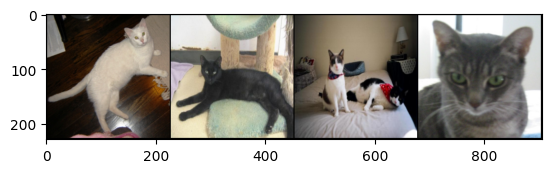

Cat Cat Cat Cat


In [24]:
visualize_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # You can adjust this size as needed
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

my_dataset = CatAndDogsDataset('kagglecatsanddogs_5340/PetImages/', train=True, transform=visualize_transform)
my_loader = data.DataLoader(my_dataset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(my_loader))
show_images(utils.make_grid(images))
classes = ['Cat', 'Dog']
print(*[classes[l] for l in labels])


## 4. Classifying the Cats and Dogs dataset with a CNN

As we have seen in class, classifying images with a multi-layer perceptron isn't really a good idea. Convolutional Neural Networks (CNN) are in fact a much better option for this task. It is now your job to create your custom CNN and train it on the Cats and Dogs Dataset.

Similarly to what you have done when classifying the CIFAR10 dataset you are again required to report and discuss the performance of your model.

Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Cat/Thumbs.db
Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Cat/666.jpg


/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Dog/Thumbs.db
Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Dog/11702.jpg
Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Cat/Thumbs.db
Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Cat/666.jpg
Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Dog/Thumbs.db
Skipping corrupted image: kagglecatsanddogs_5340/PetImages/Dog/11702.jpg
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


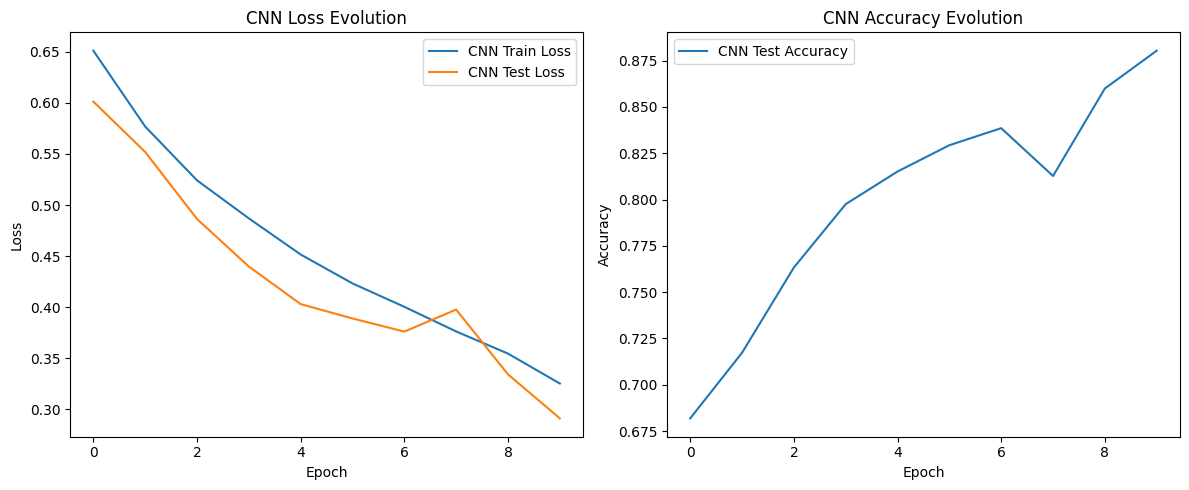

In [ ]:
num_epochs_cnn = 10
batch_size_cnn = 32
learning_rate_cnn = 0.001

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # output: (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # output: (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # output: (64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # output: (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# output: (128, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # output: (128, 16, 16)
        )
        # Assume input images are resized to 128x128
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the CNN and transfer it to the GPU
cnn = SimpleCNN(num_classes=2)
cnn = cnn.to(device)

# Loss function and optimizer
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=learning_rate_cnn)

# Transforms for training and testing, resize images to 128x128
train_transform_cnn = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
test_transform_cnn = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create training and testing datasets
train_dataset_cnn = CatAndDogsDataset('kagglecatsanddogs_5340/PetImages/', train=True, transform=train_transform_cnn)
test_dataset_cnn = CatAndDogsDataset('kagglecatsanddogs_5340/PetImages/', train=False, transform=test_transform_cnn)

trainloader_cnn = torch.utils.data.DataLoader(train_dataset_cnn, batch_size=batch_size_cnn, shuffle=True, num_workers=2)
testloader_cnn = torch.utils.data.DataLoader(test_dataset_cnn, batch_size=batch_size_cnn, shuffle=False, num_workers=2)

# Training loop
def train_cnn(num_epochs):
    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []
    
    for epoch in range(num_epochs):
        train_losses = []
        for x, y in trainloader_cnn:
            x = x.to(device)
            y = y.to(device)
            
            optimizer_cnn.zero_grad()
            outputs = cnn(x)
            loss = criterion_cnn(outputs, y)
            train_losses.append(loss.detach().item())
            loss.backward()
            optimizer_cnn.step()
        
        avg_train_loss = np.mean(train_losses)
        train_loss_history.append(avg_train_loss)
        
        test_losses = []
        correct = 0
        with torch.no_grad():
            for x, y in testloader_cnn:
                x = x.to(device)
                y = y.to(device)

                outputs = cnn(x)
                loss = criterion_cnn(outputs, y)
                test_losses.append(loss.item())
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum()

        avg_test_loss = np.mean(test_losses)
        test_loss_history.append(avg_test_loss)

        accuracy = (correct.cpu()) / len(test_dataset_cnn)
        test_accuracy_history.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}")
    
    return train_loss_history, test_loss_history, test_accuracy_history

cnn_train_loss, cnn_test_loss, cnn_test_accuracy = train_cnn(num_epochs_cnn)

# Plot the results
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(cnn_train_loss, label="CNN Train Loss")
plt.plot(cnn_test_loss, label="CNN Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Loss Evolution")
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_test_accuracy, label="CNN Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Accuracy Evolution")
plt.legend()
plt.tight_layout()
plt.show()

This model, reaching almost 90% accuracy, proves much more suited for this task of image classification than the MLP. It took much longer to train (almost 9 minutes!) and that was the motivation for some of the design choices such as limiting the training epochs to 10 even though it looks like the loss hasn't reduced to its full potential. However, it managed to achieve a very good performance at the end.

## Feedback

Now that you are done with this final deep-learning assignment here are some final questions about the exercises you were required to solve:

<span style="color:blue">How much time did you spend on this homework?</span>

Actually quite a while, because we also wanted to catch up with the last homework (homework 1), that we had missed by accident. We spent some time making sure to understand everything so in total it could have been around 4-5 hours in total.

<span style="color:blue">Do you feel confortable with what it means to define a neural network and train it?</span>

Overall, we think so

<span style="color:blue">Do you think you now have enough preliminary knowledge for successfully starting to work on your course final project?</span>

Yes, besides we are going to use a CNN

<span style="color:blue">If you had to go through the two homeworks again, is there something you would have liked to explore more or explained more into detail?</span>

It was very well explained overall, if we had to say something maybe add a little summary with the key steps of using pytorch to better wrap it all up.